# Import libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import roc_curve, roc_auc_score, classification_report
from sklearn.preprocessing import OneHotEncoder, StandardScaler
import xgboost as xgb
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer

from scipy.stats import ttest_ind


%matplotlib inline



# Load dataset

In [2]:
borrower_df= pd.read_csv("./raw_data/borrower_table.csv")
loan_df= pd.read_csv("./raw_data/loan_table.csv", parse_dates=['date'])

# Dataset inspection

In [3]:
borrower_df.head()

,loan_id,is_first_loan,fully_repaid_previous_loans,currently_repaying_other_loans,total_credit_card_limit,avg_percentage_credit_card_limit_used_last_year,saving_amount,checking_amount,is_employed,yearly_salary,age,dependent_number
0,289774,1,NaN,NaN,8000,0.49,3285,1073,0,0,47,3
1,482590,0,1.0,0.0,4500,1.03,636,5299,1,13500,33,1
2,135565,1,NaN,NaN,6900,0.82,2085,3422,1,24500,38,8
3,207797,0,1.0,0.0,1200,0.82,358,3388,0,0,24,1
4,828078,0,0.0,0.0,6900,0.80,2138,4282,1,18100,36,1


In [4]:
borrower_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101100 entries, 0 to 101099
Data columns (total 12 columns):
 #   Column                                           Non-Null Count   Dtype  
---  ------                                           --------------   -----  
 0   loan_id                                          101100 non-null  int64  
 1   is_first_loan                                    101100 non-null  int64  
 2   fully_repaid_previous_loans                      46153 non-null   float64
 3   currently_repaying_other_loans                   46153 non-null   float64
 4   total_credit_card_limit                          101100 non-null  int64  
 5   avg_percentage_credit_card_limit_used_last_year  94128 non-null   float64
 6   saving_amount                                    101100 non-null  int64  
 7   checking_amount                                  101100 non-null  int64  
 8   is_employed                                      101100 non-null  int64  
 9   yearly_salary  

In [5]:
borrower_df.isnull().sum()/len(borrower_df)

loan_id                                            0.000000
is_first_loan                                      0.000000
fully_repaid_previous_loans                        0.543492
currently_repaying_other_loans                     0.543492
total_credit_card_limit                            0.000000
avg_percentage_credit_card_limit_used_last_year    0.068961
saving_amount                                      0.000000
checking_amount                                    0.000000
is_employed                                        0.000000
yearly_salary                                      0.000000
age                                                0.000000
dependent_number                                   0.000000
dtype: float64

In [6]:
loan_df.head()

,loan_id,loan_purpose,date,loan_granted,loan_repaid
0,19454,investment,2012-03-15,0,NaN
1,496811,investment,2012-01-17,0,NaN
2,929493,other,2012-02-09,0,NaN
3,580653,other,2012-06-27,1,1.0
4,172419,business,2012-05-21,1,0.0


In [7]:
loan_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101100 entries, 0 to 101099
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   loan_id       101100 non-null  int64         
 1   loan_purpose  101100 non-null  object        
 2   date          101100 non-null  datetime64[ns]
 3   loan_granted  101100 non-null  int64         
 4   loan_repaid   47654 non-null   float64       
dtypes: datetime64[ns](1), float64(1), int64(2), object(1)
memory usage: 3.9+ MB


In [8]:
loan_df.isnull().sum()/len(loan_df)

loan_id         0.000000
loan_purpose    0.000000
date            0.000000
loan_granted    0.000000
loan_repaid     0.528645
dtype: float64

# Merge the dataframe

In [9]:
df= pd.merge(left=loan_df, right= borrower_df, on= "loan_id")

In [10]:
df.head()

,loan_id,loan_purpose,date,loan_granted,loan_repaid,is_first_loan,fully_repaid_previous_loans,currently_repaying_other_loans,total_credit_card_limit,avg_percentage_credit_card_limit_used_last_year,saving_amount,checking_amount,is_employed,yearly_salary,age,dependent_number
0,19454,investment,2012-03-15,0,NaN,1,NaN,NaN,8600,0.79,1491,6285,1,45200,42,7
1,496811,investment,2012-01-17,0,NaN,1,NaN,NaN,5300,0.52,141,5793,0,0,42,5
2,929493,other,2012-02-09,0,NaN,1,NaN,NaN,0,NaN,660,3232,1,26500,60,4
3,580653,other,2012-06-27,1,1.0,0,1.0,0.0,5400,0.52,3345,2764,1,15800,58,4
4,172419,business,2012-05-21,1,0.0,1,NaN,NaN,2900,0.76,1050,3695,1,34800,31,4


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 101100 entries, 0 to 101099
Data columns (total 16 columns):
 #   Column                                           Non-Null Count   Dtype         
---  ------                                           --------------   -----         
 0   loan_id                                          101100 non-null  int64         
 1   loan_purpose                                     101100 non-null  object        
 2   date                                             101100 non-null  datetime64[ns]
 3   loan_granted                                     101100 non-null  int64         
 4   loan_repaid                                      47654 non-null   float64       
 5   is_first_loan                                    101100 non-null  int64         
 6   fully_repaid_previous_loans                      46153 non-null   float64       
 7   currently_repaying_other_loans                   46153 non-null   float64       
 8   total_credit_card_limit 

# Filter the dataframe to only select the information where the loan is granted as this is for profit analysis
For profit analysis, person who do not granted with loan will not bring any profit to the bank.
We will exclude that group of person from the dataframe

In [12]:
df['loan_granted'].value_counts(normalize=True)


0    0.528645
1    0.471355
Name: loan_granted, dtype: float64

In [13]:
df=df[df['loan_granted']==1]


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 47654 entries, 3 to 101098
Data columns (total 16 columns):
 #   Column                                           Non-Null Count  Dtype         
---  ------                                           --------------  -----         
 0   loan_id                                          47654 non-null  int64         
 1   loan_purpose                                     47654 non-null  object        
 2   date                                             47654 non-null  datetime64[ns]
 3   loan_granted                                     47654 non-null  int64         
 4   loan_repaid                                      47654 non-null  float64       
 5   is_first_loan                                    47654 non-null  int64         
 6   fully_repaid_previous_loans                      21865 non-null  float64       
 7   currently_repaying_other_loans                   21865 non-null  float64       
 8   total_credit_card_limit            

In [15]:
df.isnull().sum()/len(df)

loan_id                                            0.000000
loan_purpose                                       0.000000
date                                               0.000000
loan_granted                                       0.000000
loan_repaid                                        0.000000
is_first_loan                                      0.000000
fully_repaid_previous_loans                        0.541172
currently_repaying_other_loans                     0.541172
total_credit_card_limit                            0.000000
avg_percentage_credit_card_limit_used_last_year    0.018949
saving_amount                                      0.000000
checking_amount                                    0.000000
is_employed                                        0.000000
yearly_salary                                      0.000000
age                                                0.000000
dependent_number                                   0.000000
dtype: float64

In [16]:
# Extract the year and month component from the dataframe and drop the original date column as it is no longer useful
df['month']= df['date'].dt.month
df['year']= df['date'].dt.year
df.drop(columns=['loan_id','date','loan_granted'], inplace= True)


# Data visualization

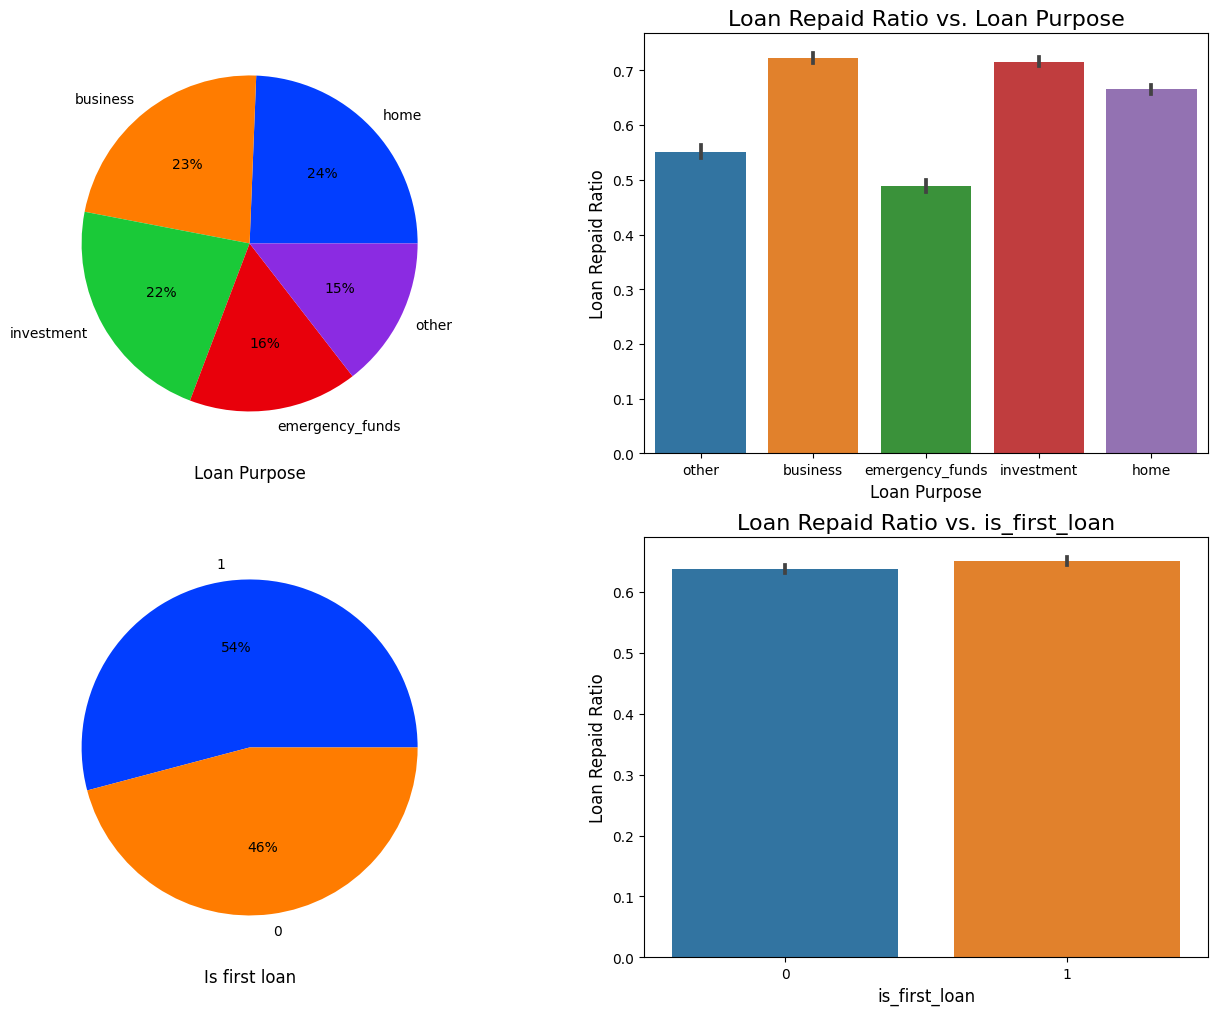

In [17]:
fig, ax= plt.subplots(nrows= 2, ncols= 2, figsize= (16,12))
color= sns.color_palette("bright")
categories= df['loan_purpose'].value_counts()
label= categories.index
ax[0,0].pie(categories, labels= label, colors= color, autopct= "%.0f%%")
ax[0,0].set_xlabel('Loan Purpose', fontsize=12)

sns.barplot(x='loan_purpose', y='loan_repaid', data=df, ax=ax[0, 1])
ax[0, 1].set_xlabel('Loan Purpose', fontsize=12)
ax[0, 1].set_ylabel('Loan Repaid Ratio', fontsize=12)
ax[0, 1].set_title('Loan Repaid Ratio vs. Loan Purpose', fontsize=16)

color= sns.color_palette("bright")
categories= df['is_first_loan'].value_counts()
label= categories.index
ax[1,0].pie(categories, labels= label, colors= color, autopct= "%.0f%%")
ax[1,0].set_xlabel('Is first loan', fontsize=12)

sns.barplot(x='is_first_loan', y='loan_repaid', data=df, ax=ax[1, 1])
ax[1, 1].set_xlabel('is_first_loan', fontsize=12)
ax[1, 1].set_ylabel('Loan Repaid Ratio', fontsize=12)
ax[1, 1].set_title('Loan Repaid Ratio vs. is_first_loan', fontsize=16)

plt.show()

Loan purpose proportion is about similar for home, business and investment which is around 23%. 

Loan repaid ratio for emergency fund is the less which is only close to 50%.

The loan repaid ratio does not show much difference between the group of borrower who are taking a loan for the first time and those who are not.



In [18]:
df.head()

,loan_purpose,loan_repaid,is_first_loan,fully_repaid_previous_loans,currently_repaying_other_loans,total_credit_card_limit,avg_percentage_credit_card_limit_used_last_year,saving_amount,checking_amount,is_employed,yearly_salary,age,dependent_number,month,year
3,other,1.0,0,1.0,0.0,5400,0.52,3345,2764,1,15800,58,4,6,2012
4,business,0.0,1,NaN,NaN,2900,0.76,1050,3695,1,34800,31,4,5,2012
6,business,1.0,0,1.0,0.0,7800,0.30,4206,4368,1,51100,51,2,3,2012
7,emergency_funds,0.0,0,0.0,1.0,4300,1.02,886,1597,1,15000,59,2,8,2012
8,investment,1.0,0,1.0,0.0,3900,0.65,1837,3795,1,12000,24,1,5,2012


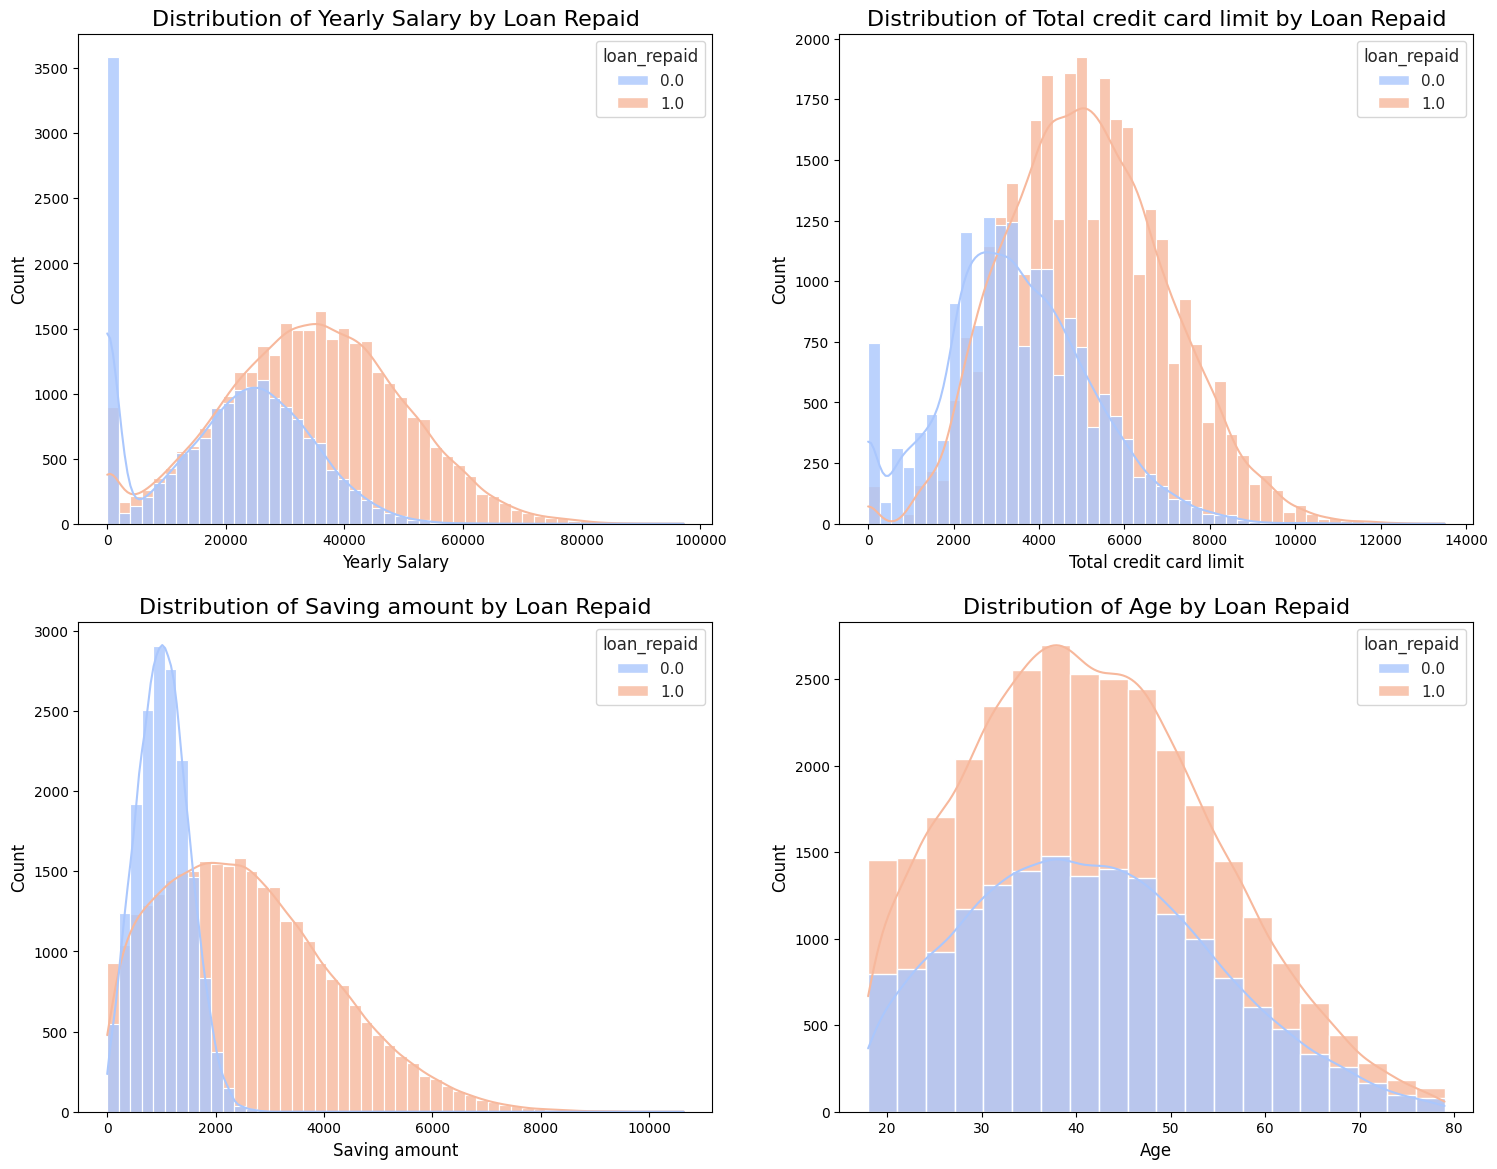

In [19]:
fig, ax= plt.subplots(nrows= 2, ncols= 2, figsize= (18,14))
sns.set(style='whitegrid')
sns.histplot(data= df, x= 'yearly_salary', bins= 50, hue= 'loan_repaid', kde= True, palette='coolwarm', alpha= 0.8, ax=ax[0,0])
ax[0,0].set_xlabel('Yearly Salary', fontsize=12)
ax[0,0].set_ylabel('Count', fontsize=12)
ax[0,0].set_title('Distribution of Yearly Salary by Loan Repaid', fontsize=16)

sns.histplot(data= df, x= 'total_credit_card_limit', bins= 50, hue= 'loan_repaid', kde= True, palette='coolwarm', alpha= 0.8, ax=ax[0,1])
ax[0,1].set_xlabel('Total credit card limit', fontsize=12)
ax[0,1].set_ylabel('Count', fontsize=12)
ax[0,1].set_title('Distribution of Total credit card limit by Loan Repaid', fontsize=16)

sns.histplot(data= df, x= 'saving_amount', bins= 50, hue= 'loan_repaid', kde= True, palette='coolwarm', alpha= 0.8, ax=ax[1,0])
ax[1,0].set_xlabel('Saving amount', fontsize=12)
ax[1,0].set_ylabel('Count', fontsize=12)
ax[1,0].set_title('Distribution of Saving amount by Loan Repaid', fontsize=16)

sns.histplot(data= df, x= 'age', bins= 20, hue= 'loan_repaid', kde= True, palette='coolwarm', alpha= 0.8, ax=ax[1,1])
ax[1,1].set_xlabel('Age', fontsize=12)
ax[1,1].set_ylabel('Count', fontsize=12)
ax[1,1].set_title('Distribution of Age by Loan Repaid', fontsize=16)

plt.show()

It is quite obvious that the higher the amount of yearly salary and the saving amount, the loan repaid ratio is higher.

# A/B testing

H0: There is no significant different in yearly salary between two groups of borrower.

Ha: There is a significant different in yearly salary between two groups of borrower.

In [20]:
group_loan_repaid= np.array(df[df['loan_repaid']==1]['yearly_salary'])
group_loan_nopaid= np.array(df[df['loan_repaid']==0]['yearly_salary'])
t_stat, p_value= ttest_ind(group_loan_repaid, group_loan_nopaid, equal_var=True)
alpha = 0.05  # significance level
if p_value < alpha:
    print("There is a significant different in yearly salary between two groups of borrower.")
else:
    print("There is no significant different in yearly salary between two groups of borrower.")


There is a significant different in yearly salary between two groups of borrower.


# Visualization of correlation

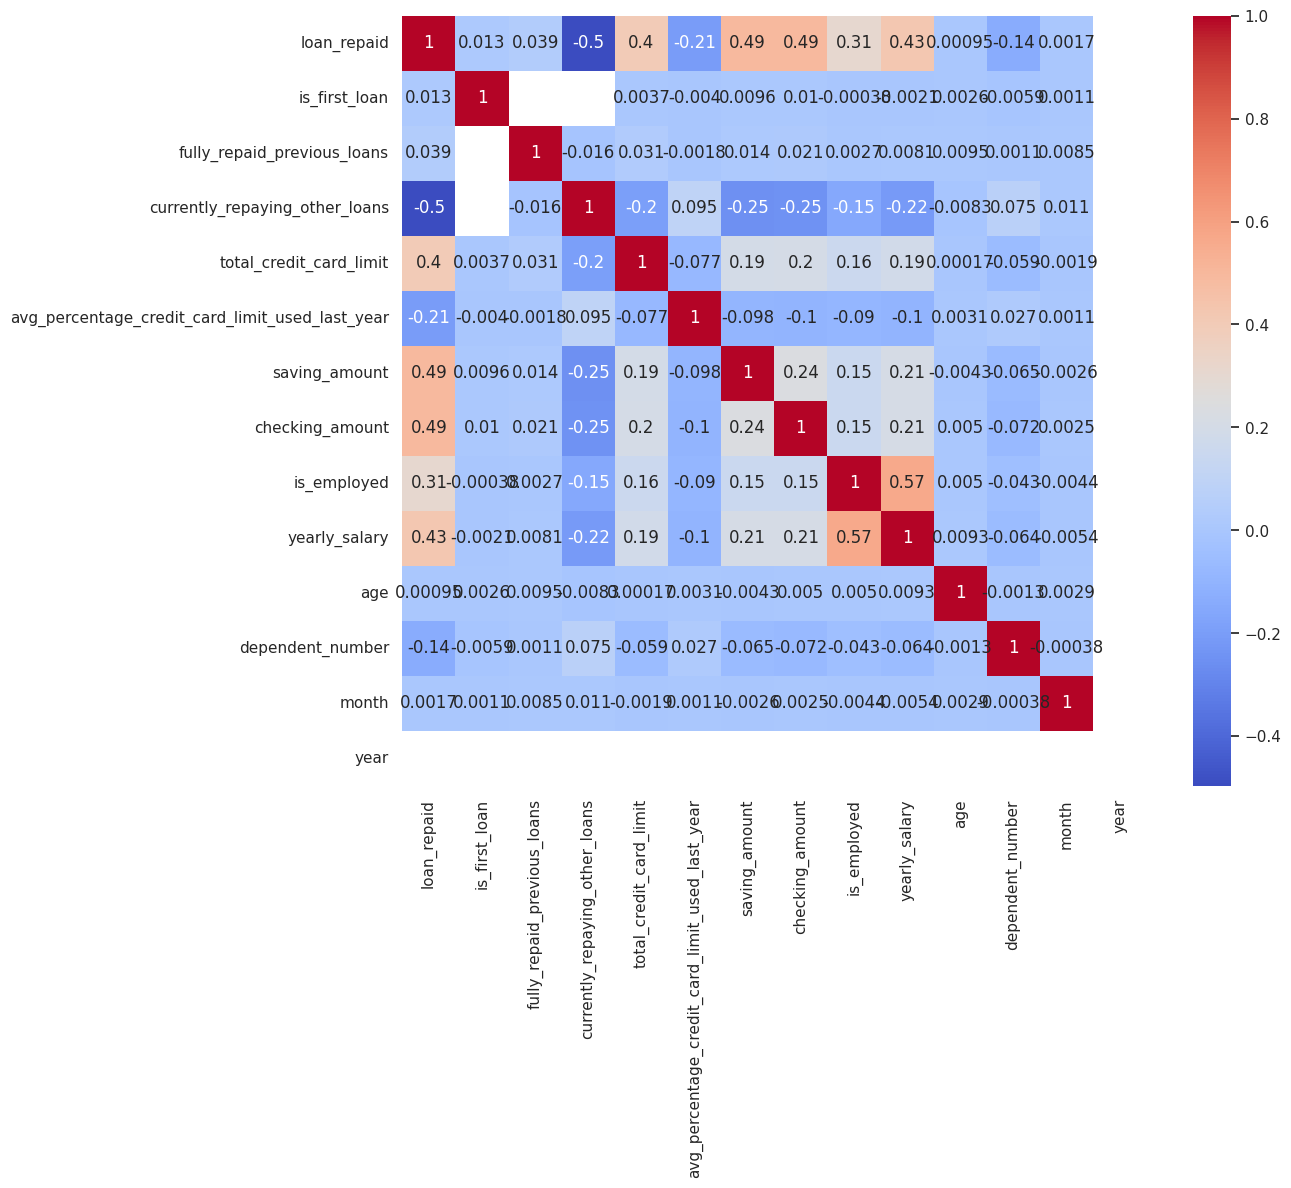

In [21]:
plt.figure(figsize=(12,10))
sns.heatmap(df.corr(), annot= True, cmap= "coolwarm")
plt.show()

# Feature engineering

Check the is first loan column and the relationship of the columns of fully repaid previous loan and currently
repaying other loans


In [22]:
df[df['is_first_loan']==1]['fully_repaid_previous_loans'].unique()

array([nan])

In [23]:
df[df['is_first_loan']==1]['currently_repaying_other_loans'].unique()

array([nan])

If a person is having the loan for the first time, it is for sure that there is no data for fully repaid previous loan and there is no data for currently
repaying other loans. 
In order to deal with this missing value in this two columns, we assign -1 to let the model distinguish that -1 in that two columns mean the person is having the first loan so there is no data in that two columns.
Since this condition ady been considered in that two columns, so we can eventually drop the is first loan column else all these two columns will have a 
clear connection go is first loan column.

In [24]:
df.fillna(value= {'fully_repaid_previous_loans': -1, 'currently_repaying_other_loans': -1}, inplace= True)
df.drop(columns= ['is_first_loan'], inplace= True)

Fill the missing value in avg_percentage_credit_card_limit_used_last_year with median value

In [25]:
fill_avg_percentage_credit_card_limit_used_last_year_median= df['avg_percentage_credit_card_limit_used_last_year'].median()
df.fillna(value= {'avg_percentage_credit_card_limit_used_last_year': fill_avg_percentage_credit_card_limit_used_last_year_median}, inplace= True)

In [26]:
df.drop(columns= ['month', 'year'], inplace= True)

In [27]:
# Traning dataframe
df.head()

,loan_purpose,loan_repaid,fully_repaid_previous_loans,currently_repaying_other_loans,total_credit_card_limit,avg_percentage_credit_card_limit_used_last_year,saving_amount,checking_amount,is_employed,yearly_salary,age,dependent_number
3,other,1.0,1.0,0.0,5400,0.52,3345,2764,1,15800,58,4
4,business,0.0,-1.0,-1.0,2900,0.76,1050,3695,1,34800,31,4
6,business,1.0,1.0,0.0,7800,0.30,4206,4368,1,51100,51,2
7,emergency_funds,0.0,0.0,1.0,4300,1.02,886,1597,1,15000,59,2
8,investment,1.0,1.0,0.0,3900,0.65,1837,3795,1,12000,24,1


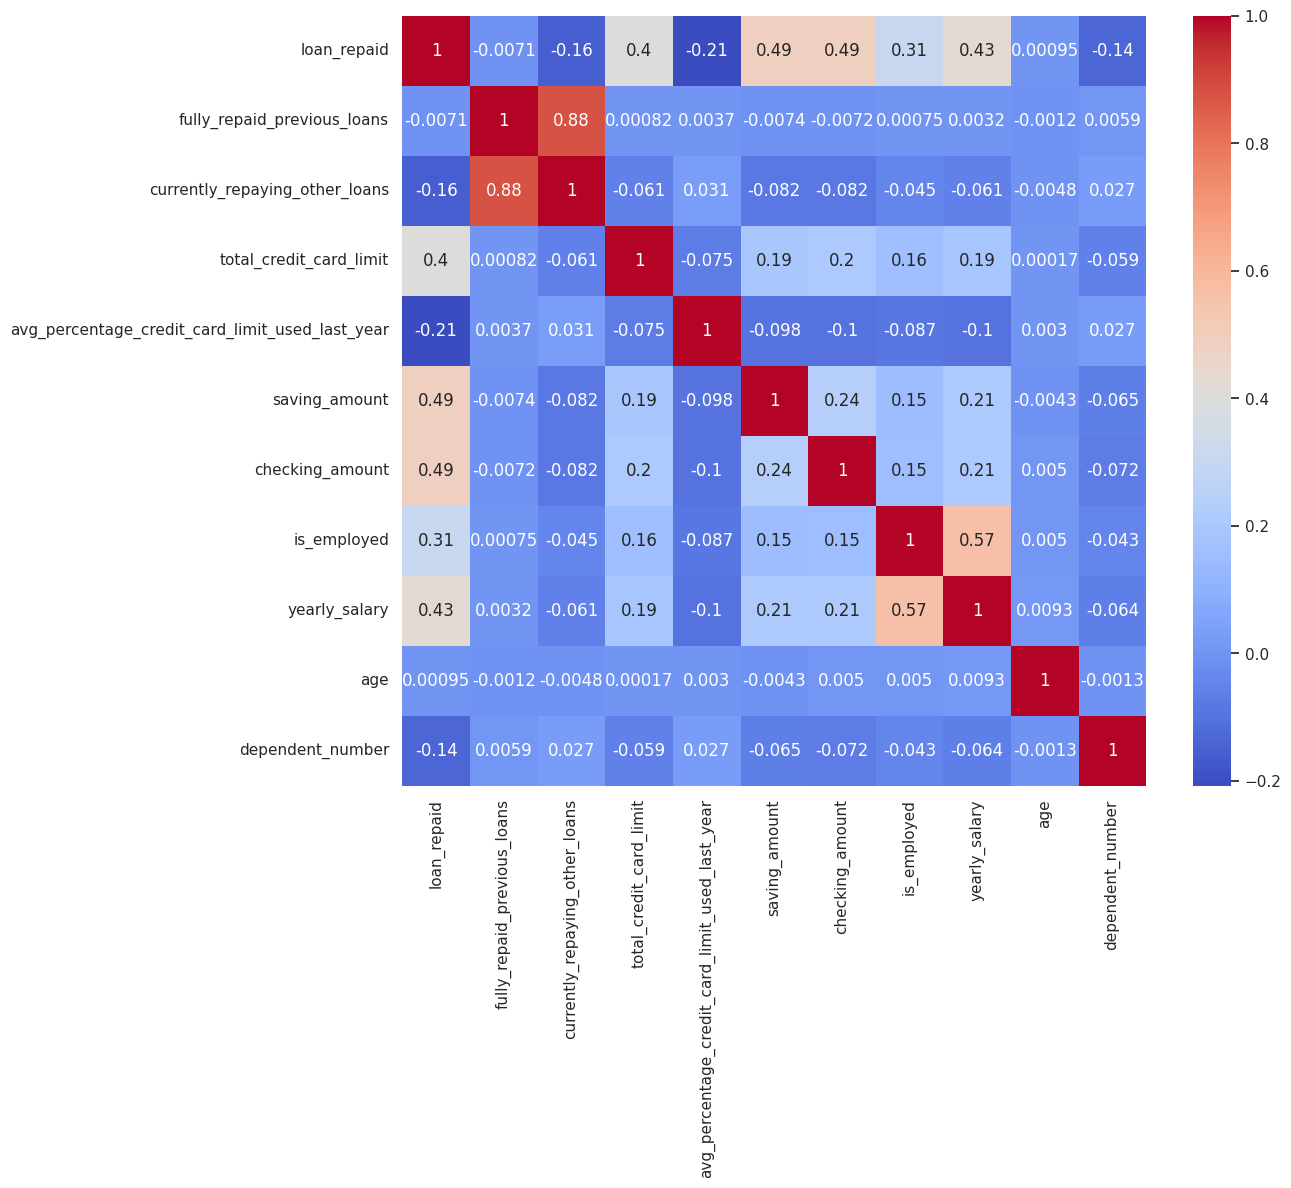

In [28]:
plt.figure(figsize=(12,10))
sns.heatmap(df.corr(), annot= True, cmap= "coolwarm")
plt.show()

# Machine learning

In [29]:
cat_feature= ['loan_purpose', 'loan_repaid', 'fully_repaid_previous_loans', 'currently_repaying_other_loans', 'is_employed']
df[cat_feature]= df[cat_feature].astype('category')


In [30]:
# Define feature and target
X= df.drop(columns= ['loan_repaid'])
y= df['loan_repaid']


In [31]:
X_train, X_test, y_train, y_test= train_test_split(X, y, test_size= 0.2, stratify= y, random_state= 42 )

In [32]:
encoder_cat_feature= X.select_dtypes('category').columns
scaler_num_feature= X.select_dtypes(['float','int']).columns


In [33]:
cat_transformer= make_pipeline(OneHotEncoder(drop= 'if_binary', sparse= False))
num_transformer= make_pipeline(StandardScaler())
feature_processing= make_column_transformer((cat_transformer,encoder_cat_feature),(num_transformer,scaler_num_feature))
feature_processing

ColumnTransformer(transformers=[('pipeline-1',
                                 Pipeline(steps=[('onehotencoder',
                                                  OneHotEncoder(drop='if_binary',
                                                                sparse=False))]),
                                 Index(['loan_purpose', 'fully_repaid_previous_loans',
       'currently_repaying_other_loans', 'is_employed'],
      dtype='object')),
                                ('pipeline-2',
                                 Pipeline(steps=[('standardscaler',
                                                  StandardScaler())]),
                                 Index(['total_credit_card_limit',
       'avg_percentage_credit_card_limit_used_last_year', 'saving_amount',
       'checking_amount', 'yearly_salary', 'age', 'dependent_number'],
      dtype='object'))])

In [34]:
X_train_transform= feature_processing.fit_transform(X_train)


In [35]:
num_get_name= feature_processing.named_transformers_['pipeline-2'].named_steps['standardscaler'].get_feature_names_out(input_features= scaler_num_feature).tolist()
cat_get_name= feature_processing.named_transformers_['pipeline-1'].named_steps['onehotencoder'].get_feature_names_out(input_features= encoder_cat_feature).tolist()
get_all_name= cat_get_name+ num_get_name

In [36]:
# Drop either fully_repaid_previous_loans_-1.0 or currently_repaying_other_loans_-1.0 since there are both same. 
X_train_transform= pd.DataFrame(X_train_transform, columns= get_all_name)
X_train_transform= X_train_transform.drop(columns= ['fully_repaid_previous_loans_-1.0'])

In [37]:
# Traning feature ready
X_train_transform.shape

(38123, 18)

In [38]:
# Repeat the same processing step for test feature
X_test_transform= feature_processing.transform(X_test)
X_test_transform= pd.DataFrame(X_test_transform, columns= get_all_name)
X_test_transform= X_test_transform.drop(columns= ['fully_repaid_previous_loans_-1.0'])

In [39]:
# Testing feature ready
X_test_transform.shape

(9531, 18)

In [40]:
model_xg= xgb.XGBClassifier(booster= 'gbtree', learning_rate= 0.01, max_depth= 6, eval_metric= 'auc')

In [41]:
cv_xg= cross_validate(model_xg, X_train_transform, y_train,cv= 5, scoring= 'roc_auc', n_jobs= -1)
cv_xg

{'fit_time': array([2.40230346, 2.41091633, 2.43122149, 2.45283437, 2.42362332]),
 'score_time': array([0.01269674, 0.01216912, 0.01256776, 0.01124811, 0.01184154]),
 'test_score': array([0.96852107, 0.97093197, 0.97041637, 0.97179789, 0.96932753])}

In [42]:
model_xg.fit(X_train_transform,y_train)


XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

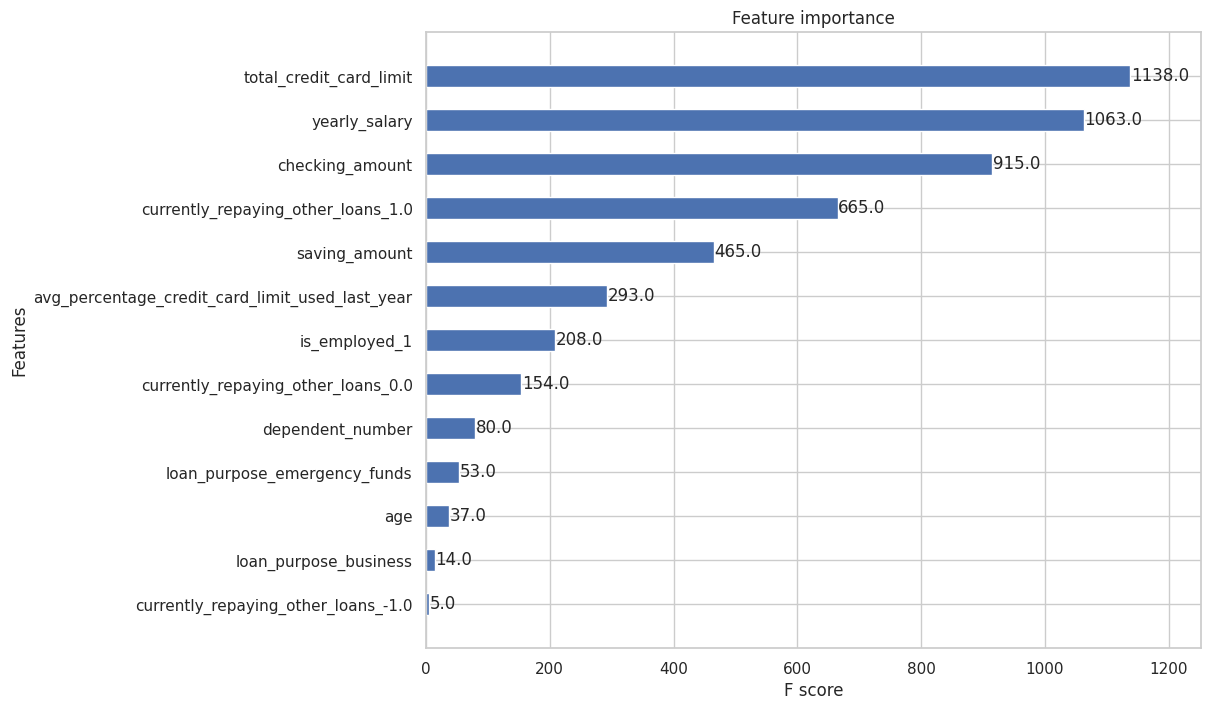

In [43]:
fig, ax = plt.subplots(figsize=(10, 8))
xgb.plot_importance(model_xg, ax= ax, height=0.5)

In [44]:
# Collect all the positive predict proba
y_predict_proba= model_xg.predict_proba(X_test_transform)[:,1]
y_predict= model_xg.predict(X_test_transform)

In [45]:
# Plot RUC_curve
fpr, tpr, thresholds= roc_curve(y_test, y_predict_proba)
auc_score= roc_auc_score(y_test, y_predict_proba )


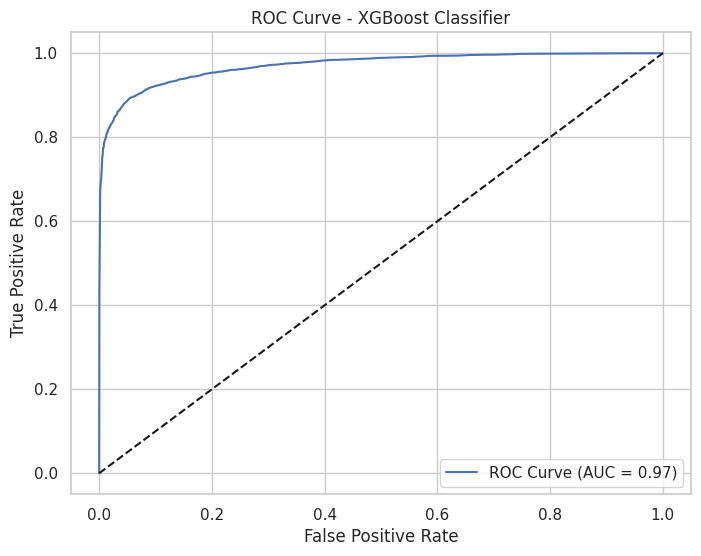

In [46]:
sns.set_style("whitegrid")
plt.figure(figsize=(8, 6))
sns.lineplot(x= fpr, y= tpr, label=f'ROC Curve (AUC = {auc_score:.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line for random classifier
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - XGBoost Classifier')
plt.legend()
plt.show()

In [47]:
print(classification_report(y_test, y_predict))

              precision    recall  f1-score   support

         0.0       0.84      0.93      0.88      3390
         1.0       0.96      0.91      0.93      6141

    accuracy                           0.91      9531
   macro avg       0.90      0.92      0.91      9531
weighted avg       0.92      0.91      0.91      9531



# Now, let see how the model threshold can affect the bank profit

In [48]:
# Convert 0 to -1 indicate losing money because loan no repaid means losing 1 unit, 1 remain 1 means earning 1 unit
# Total profit from original bank:
y_test_transformed= y_test.astype(int).apply(lambda x: -1 if x == 0 else 1)
bank_ori_profit= y_test_transformed.sum()
print(f'Bank original profit: {bank_ori_profit}')


Bank original profit: 2751


In [49]:
# For later profit analysis purpose to convert the y_test become array
loan_paid_or_not_paid= y_test.astype('int').values
loan_paid_or_not_paid

array([1, 1, 1, ..., 1, 1, 0])

In [50]:
def count_profit(loan_paid_or_not_paid, predict_proba, threshold):
    grant= (predict_proba> threshold).astype('int')
    profit=0
    for i in range(len(grant)):
        if grant[i]==1:
            if loan_paid_or_not_paid[i]==1:
                profit+= 1
            else:
                profit-= 1
    return profit
            


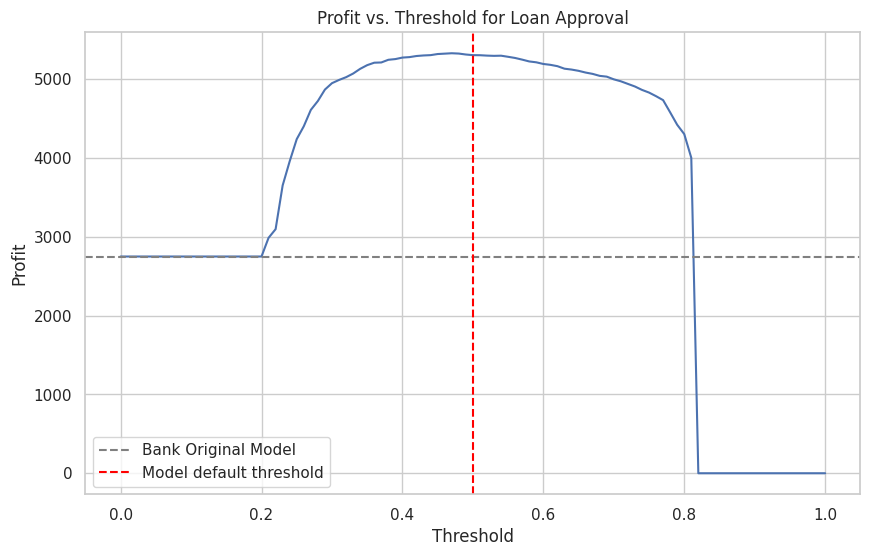

In [51]:
threshold_list= np.arange(0,1.01,0.01)
profit_list=[]
for i in threshold_list:
    profit_list.append(count_profit(loan_paid_or_not_paid, y_predict_proba, i))
    
sns.set(style='whitegrid')
plt.figure(figsize=(10, 6))

# Plot the profit vs. threshold
sns.lineplot(x= threshold_list, y= profit_list)

# Set labels and title
plt.xlabel('Threshold')
plt.ylabel('Profit')
plt.title('Profit vs. Threshold for Loan Approval')

# Add bank_ori_profit for reference
plt.axhline(bank_ori_profit, color='gray', linestyle='--', label='Bank Original Model')
plt.axvline(0.5, color='red', linestyle='--', label='Model default threshold')

plt.legend()
plt.show()

# Conclusion
If this model is built on top of bank original model, it can further increase the bank profit as long as the threshold is set between 0.2 to 0.8.

# Recap 
Since the beginning, the dataset has been filtered to only loan granted data. So we can assume that the bank original model can only bring the profit of 2751. All of our analysis is done on the loan granted data, so it can be said that the new model is built on top of the bank original model. It means we do another round filtering to filter out the loan granted personnel based on bank original model. So in short, this model is to futher filter out the person who is initially ady being granted based on original bank model. Implementing of this model on top of bank original model, the conclusion showed that it can further enhance the profit of the bank. 